# Train Gaussian Mixture Regression

In [1]:
using AutomotiveDrivingModels
using RandomForestBehaviors

  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:7
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:9
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21
  likely near /home/tim/.julia/v0.4/StreamStats/src/hyper_log_log.jl:21


# Parameters

In [2]:
include(Pkg.dir("AutomotiveDrivingModels", "scripts", "extract_params.jl"))
nothing

In [3]:
dset_filepath_modifier = "_following" # _freeflow, _following, _lanechange

"_following"

In [4]:
dset = JLD.load(joinpath(EVALUATION_DIR, "dataset2" * dset_filepath_modifier * ".jld"),
                "model_training_data")::ModelTrainingData2
runlogs_original = load_runlogs(dset)
streetnets = load_streetnets(runlogs_original)

fold = 1
cv_split_outer = get_fold_assignment_across_drives(dset, N_FOLDS)
cv_split_inner = drop_fold!(deepcopy(cv_split_outer), fold)
@assert(cv_split_inner.nfolds > 0)

ntraces = length(cv_split_outer.seg_assignment);

## Optimize Hyperparams

In [13]:
train_def = BehaviorTrainDefinition(
                                    BehaviorTrainDefinition(
                                             GMR_TrainParams(
                                                 indicators=INDICATOR_SET2,
                                                 max_n_indicators=5,
                                                 fraction_test=0.2,
                                                 min_covar=1e-5,
                                                 n_components=50,
                                                 n_PCA_features=0,
                                                 ),
                                             [
                                                 BehaviorParameter(:n_components, [2,5,10], 1),
                                                 BehaviorParameter(:n_PCA_features, [0,5,10], 1),
                                             ]))

preallocated_data = preallocate_learning_data(dset, train_def.trainparams)
print(train_def); sleep(0.1)

BehaviorTrainDefinition
GMR Train Params
	targets: (:f_des_angle,:f_accel)
	indicators: [:posFyaw,:posFt,:speed,:velBx,:velBy,:velFs,:velFt,:turnrate,:acc,:accFs,:accFt,:accBx,:accBy,:d_ml,:d_mr,:ttcr_ml,:ttcr_mr,:est_ttcr,:a_req_stayinlane,:n_lane_left,:n_lane_right,:has_lane_right,:has_lane_left,:curvature]
	n_components:     50
	max_n_indicators: 5
	n_PCA_features:   0
	min_covar:        1.0e-5

hyperparams:
	n_components:        [>2<, 5, 10]
	n_PCA_features:      [>0<, 5, 10]


In [6]:
# AutomotiveDrivingModels.optimize_hyperparams_cyclic_coordinate_ascent!(
#                     train_def, dset, preallocated_data, cv_split_inner)
# print(train_def); sleep(0.1)

## Train

In [14]:
GM = train(dset, preallocated_data, train_def.trainparams, fold, cv_split_outer, true);
print(GM)
sleep(0.1)

passed!
                 posFyaw: 2656.366099
                   posFt: 2202.484363
                   speed: -310335.260527
                   velBx: -310330.720061
                   velBy: 3274.038323
                   velFs: -296588.432013
                   velFt: 2202.343219
                turnrate: 1746.388458
                     acc: -17846.160294
                   accFs: -16945.369293
                   accFt: 3571.670289
                   accBx: -8322.981356
                   accBy: 5098.896254
                    d_ml: 917.757415
                    d_mr: 1783.335890
                 ttcr_ml: 4327.063506
                 ttcr_mr: 4348.554525
                est_ttcr: 4471.044190
        a_req_stayinlane: 4378.997885
             n_lane_left: 2584.405409
            n_lane_right: 364.641669
          has_lane_right: 161.458721
           has_lane_left: 2468.010756
               curvature: 3453.891248

chosen_indicators: [13]  5098.896253947735
passed!
                 

## Likelihood

In [15]:
arr_logl_train = Float64[]
arr_logl_test = Float64[]
for frameind in 1 : nrow(dset.dataframe)
    if trains_with_nona(GM)
        logl = calc_action_loglikelihood(GM, dset.dataframe_nona, frameind)
    else
        logl = calc_action_loglikelihood(GM, dset.dataframe, frameind)
    end
    
    if is_in_fold(fold, cv_split_outer.frame_assignment[frameind], true)
        push!(arr_logl_test, logl)
    else
        push!(arr_logl_train, logl)
    end
end

@printf("%10s  %10s  %10s  %10s\n", "min", "mean", "median", "max")
@printf("%10.4f  %10.4f  %10.4f  %10.4f\n", minimum(arr_logl_train), mean(arr_logl_train), median(arr_logl_train), maximum(arr_logl_train))
@printf("%10.4f  %10.4f  %10.4f  %10.4f\n", minimum(arr_logl_test), mean(arr_logl_test), median(arr_logl_test), maximum(arr_logl_test))

j          wⱼ  pdf(Nⱼ, f)
 1    0.130316    0.000000
 2    0.004254    0.000000
 3    0.004639    0.000000
 4    0.003772    0.000000
 5    0.015051    0.000000
 6    0.004133    0.000000
 7    0.002232    0.000000
 8    0.013274    0.000000
 9    0.016488    0.000000
10    0.000927    0.000000
11    0.013925    0.000000
12    0.004330    0.000000
13    0.001240    0.000000
14    0.356596    0.000000
15    0.084517    0.000000
16    0.002496    0.000000
17    0.009224    0.000000
18    0.001243    0.000000
19    0.003569    0.000000
20    0.013619    0.000000
21    0.008725    0.000000
22    0.006226    0.000000
23    0.010462    0.000000
24    0.004766    0.000000
25    0.002845    0.000000
26    0.003046    0.000000
27    0.001822    0.000000
28    0.002761    0.000000
29    0.006213    0.000000
30    0.070891    0.000000
31    0.001252    0.000000
32    0.009997    0.000000
33    0.003511    0.000000
34    0.041343    0.000000
35    0.017425    0.000000
36    0.001092    0.000000
37

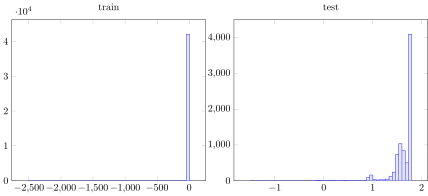

In [11]:
using PGFPlots
g = GroupPlot(2,1)
push!(g, Axis(Plots.Histogram(arr_logl_train, bins=50), ymin=0, title="train"))
push!(g, Axis(Plots.Histogram(arr_logl_test, bins=50), ymin=0, title="test"))
g

ninliers:   7967 (99.35 percent)
noutliers:    52 ( 0.65 percent)
mean logl:     1.653290
median logl:   1.742506


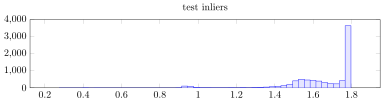

In [10]:
# Given:
#    data - a set of observed data points
#    model - a model that can be fitted to data points
#    n - the minimum number of data values required to fit the model
#    k - the maximum number of iterations allowed in the algorithm
#    t - a threshold value for determining when a data point fits a model
#    d - the number of close data values required to assert that a model fits well to data
# Return:
#    bestfit - model parameters which best fit the data (or nil if no good model is found)

using Distributions

data = arr_logl_test
m = length(data)
model = Normal
n = 10
k = 10
t = -4 # log likelihood
d = m*0.6 # 90% of the dataset
        
iterations = 0
bestfit = NaN
bestninliers = 0
besterr = Inf
bestdata = Float64[]
best_median_logl = NaN
while iterations < k
    
    maybeinliers = randperm(m)[1:n] # n randomly selected values from data
    maybemodel = fit_mle(model, data[maybeinliers]) # model parameters fitted to maybeinliers
    alsoinliers = Int[] # empty set
    
    for (i,v) in enumerate(data)
        if !in(i, maybeinliers)
            if logpdf(maybemodel, v) > t # point fits maybemodel with an error smaller than t
                push!(alsoinliers, i) # add point to alsoinliers
            end
        end
    end

    
    if length(alsoinliers) > d
        # this implies that we may have found a good model
        # now test how good it is
        fitdata = data[[maybeinliers; alsoinliers]]
        bettermodel = fit_mle(model, fitdata) # model parameters fitted to all points in maybeinliers and alsoinliers
        thiserr = sum(v->logpdf(bettermodel, v), fitdata)/length(fitdata) # a measure of how well model fits these points
        
        if thiserr < besterr
            bestfit = bettermodel
            besterr = thiserr
            bestninliers = length(fitdata)
            best_median_logl = median(fitdata)
            bestdata = fitdata
        end
    end
    iterations += 1
end
@printf("ninliers:  %5d (%5.2f percent)\n", bestninliers, 100*bestninliers/m)
@printf("noutliers: %5d (%5.2f percent)\n", m-bestninliers, 100*(1.0-bestninliers/m))
@printf("mean logl:   %10.6f\n", mean(bestfit))
@printf("median logl: %10.6f\n", best_median_logl)

Axis(Plots.Histogram(bestdata, bins=50), ymin=0, title="test inliers", width="14cm", height="4cm")